# Cluster NYC Business History

## Author: Vishwajeet Shelar

# Import libraries

In [186]:
import pandas as pd
import numpy as np
import zipfile
import seaborn
import matplotlib.pylab as plt
import geopandas as gp
import datetime as dt
from sklearn.cluster import KMeans
from matplotlib import cm

%matplotlib inline

# Getting NYC ZipCodes

In [112]:
zip_codes = gp.read_file('NYC_zip_codes.geojson')
zip_codes.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [113]:
zip_codes = zip_codes.drop([ u'@id', u'BLDGpostalCode', u'PO_NAME', u'CTY_FIPS', u'ST_FIPS',
                             u'STATE', u'OBJECTID', u'Shape_Area', u'borough', u'Shape_Leng'], 
                           axis = 1)
zip_codes = zip_codes.rename(columns={'postalCode' : 'zip_code'})
zip_codes['zip_code'] = pd.to_numeric(zip_codes['zip_code'], errors = 'coerce')
zip_codes.head()

,geometry,zip_code
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365


# Cleaning NYC Business data from year 1994 to 2014 and merging with NYC Zip Code data

In [114]:
year = []
for i in range(94, 100, 1):
    year.append(str(i))
for i in range(0, 10, 1):
    year.append('0'+str(i))
for i in range(10, 15, 1):
    year.append(str(i))

In [115]:
for i in year:
    zf = zipfile.ZipFile('zbp'+i+'totals.zip')
    temp = pd.read_csv(zf.open('zbp'+i+'totals.zip'.replace('.zip','.txt')))
    temp.columns = map(str.lower, temp.columns)
    temp = temp[['zip', 'est']]
    year = dt.datetime.strptime(str(i), '%y').year
    temp.rename(columns={'est': str(year), 'zip':'zip_code'}, inplace=True)
    zip_codes = zip_codes.merge(temp, on = 'zip_code', how = 'inner')

# Standardizing the time series

In [116]:
ts_mean = zip_codes.iloc[:,range(2,23)].mean(axis = 1)
ts_std = zip_codes.iloc[:,range(2,23)].std(axis = 1)
zip_codes.iloc[:,range(2,23)] = zip_codes.iloc[:,range(2,23)].apply(lambda x: (x-ts_mean)/ts_std)
zip_codes.head()

,geometry,zip_code,1994,1995,1996,1997,1998,1999,2000,2001,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372,-1.650515,-1.607088,-1.259673,-1.154208,-0.893647,-0.738551,-0.533825,-0.540029,...,0.272673,0.198227,0.309896,0.266469,0.477400,0.831018,0.942687,1.420382,1.637516,1.693350
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004,-0.974535,-1.248013,-1.794968,-1.065695,-0.974535,-1.339172,-1.202433,-0.518739,...,0.438432,0.484012,1.030967,0.529592,0.803069,0.620751,0.301694,1.167706,1.167706,1.577923
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040,-0.118051,-0.234030,-1.379327,-1.248850,-1.248850,-1.161866,-1.161866,-1.292342,...,0.157401,0.345867,0.838780,1.056241,0.650313,0.925765,0.838780,1.157723,1.578149,1.505662
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426,3.212291,-0.444253,-0.785986,-1.161892,-0.991026,-0.512600,-0.649293,-0.512600,...,-0.205040,-0.205040,-0.136693,-0.205040,0.170867,0.546773,0.820159,1.161892,0.888506,0.956853
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365,-1.332578,-1.549090,-1.454366,-0.926619,-1.102534,-0.967215,-0.507127,-0.222956,...,0.183004,0.237132,0.358920,0.345388,0.507772,0.710751,1.170839,1.197903,1.671522,1.901566


In [117]:
print 'After standardizing the time series, std. deviation along all zip codes: {0}\
\nAfter standardizing the time series, mean along all zip codes: {1}(~0)'.format(
    zip_codes.iloc[:,range(2,23)].std(axis = 1).sum()/len(zip_codes),
    zip_codes.iloc[:,range(2,23)].mean(axis = 1).sum()/len(zip_codes))

After standardizing the time series, std. deviation along all zip codes: 1.0
After standardizing the time series, mean along all zip codes: -2.35068968612e-17(~0)


# Clustering the data using K-means

In [190]:
#KMeans cluster
kmeans_cluster = KMeans(2).fit(zip_codes.iloc[:, range(2,23)])
centers = kmeans_cluster.cluster_centers_
zip_codes['km_labels'] = kmeans_cluster.labels_

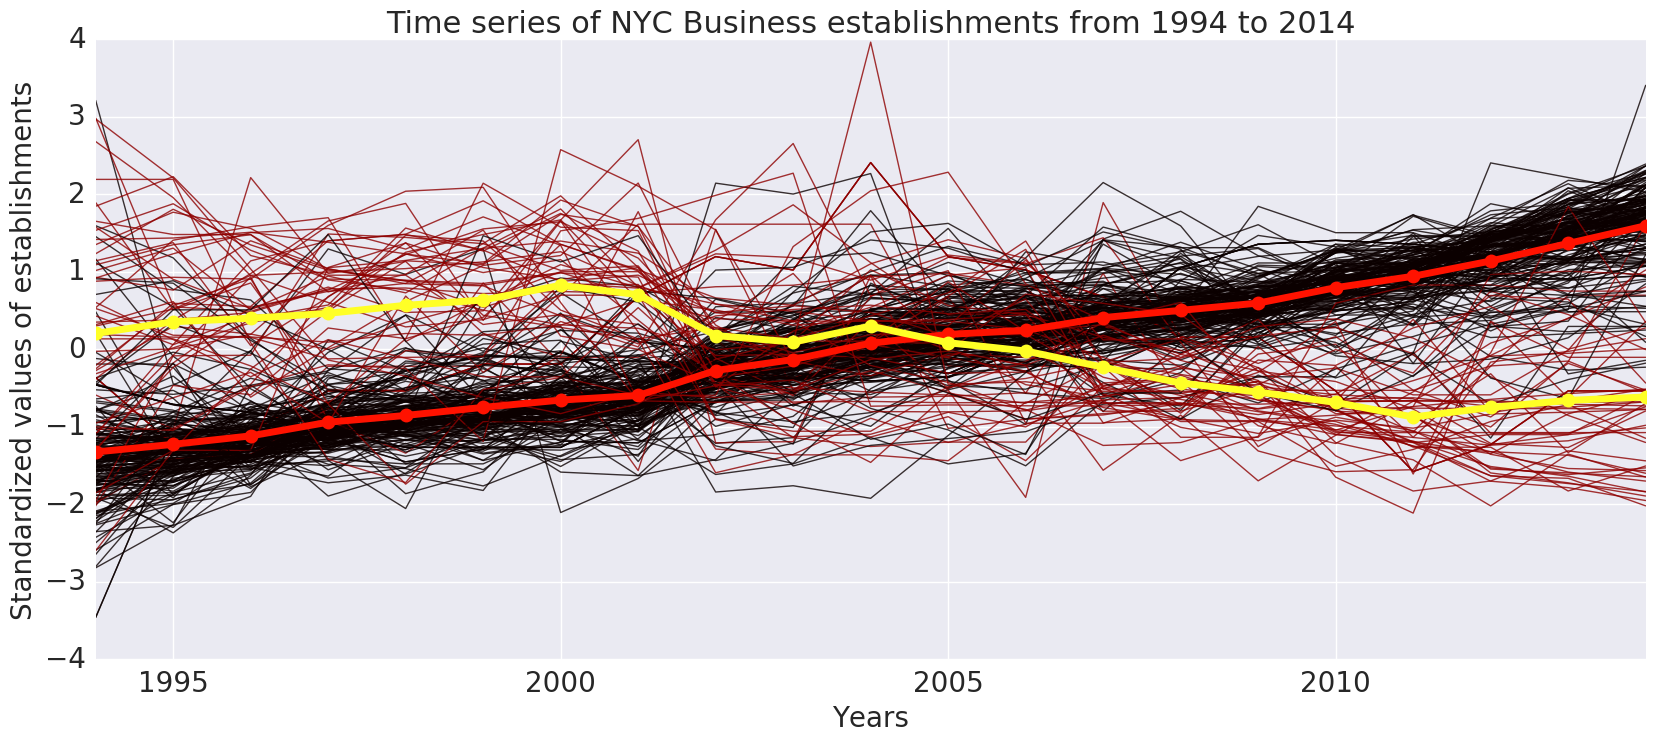

In [191]:
fig = plt.figure(figsize=(20,8))
ax = fig.gca()
for i in range(len(zip_codes)):
    ax.plot(range(1994,2015), zip_codes.iloc[i,range(2,23)], 
            '-', lw = 1, alpha = 0.8, c=cm.hot(zip_codes.km_labels[i]*50) )
plt.xlim(1994,2014)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Years", fontsize=20)
plt.ylabel("Standardized values of establishments", fontsize=20)
plt.title('Time series of NYC Business establishments from 1994 to 2014', 
          fontsize=22)
for i in range(len(centers)):
    plt.plot(range(1994,2015),centers[i], 
              '.-', ms = 20, lw = 5, c=cm.hot((i+1)*100))
# plt.legend(['Cluster 0', 'Cluster 1'], loc = 'best', fontsize=20)
plt.show()

# Figure1: The above plot shows the time series of number of business establishments in different zipcodes in NYC from 1994 to 2014. The time series of the zipcodes is standarized and clustered into 2 groups 